# Result VCT regression

In [208]:
#import warnings
#warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [306]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, plot
from phd.visualization.plot_ship import track_plots
from vessel_manoeuvring_models.prime_system import PrimeSystem
from phd.visualization.plot_prediction import plot_total_force, plot_force_components, predict, plot_compare_model_forces, plot_parameter_contributions
from phd.visualization.bokeh_plotting import create_tab
from vessel_manoeuvring_models.symbols import *
import matplotlib.pyplot as plt
from vessel_manoeuvring_models.substitute_dynamic_symbols import run, lambdify, remove_functions, prime
from vessel_manoeuvring_models.parameters import df_parameters
p = df_parameters["symbol"]
import statsmodels.api as sm
import sympy as sp
from sympy import Eq, symbols, latex
import paper
from paper import save_fig, save_eq
import yaml
with open("styles.yml", mode='r') as file:
    styles = yaml.safe_load(file)
    
from phd.pipelines.predict.nodes import score
import vessel_manoeuvring_models.models.IMO_simulations

In [210]:
#%reload_kedro
ship='wPCC'
ship_data = catalog.load(f"{ship}.ship_data")
model_loaders = catalog.load(f"{ship}.models_VCT_MDL")

df_VCT_scaled = catalog.load(f"{ship}.df_VCT_scaled")
tests_ek_smooth = catalog.load(f"{ship}.tests_ek_smooth")
tests_ek = catalog.load(f"{ship}.tests_ek")
tests_ek_joined = catalog.load(f"{ship}.tests_ek_joined")

mask = tests_ek_joined['id'].isin([
    #22774,  # Circle
    #22611,
    #22635,
    #22639,
    22769,
    22771,
])

tests_ek_smooth_joined = tests_ek_joined.loc[~mask].copy()

[01/31/24 13:03:31] INFO     Loading data from 'wPCC.ship_data' (YAMLDataSet)...                ]8;id=806281;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=462262;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.models_VCT_MDL' (PartitionedDataset)...    ]8;id=600870;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=795065;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.df_VCT_scaled' (CSVDataSet)...             ]8;id=707460;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=596233;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.tests_ek_smooth' (PartitionedDataset)...   ]8;id=210830;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=449146;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.tests_ek' (PartitionedDataset)...          ]8;id=725080;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=179190;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.tests_ek_joined' (CSVDataSet)...           ]8;id=875864;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=828124;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

In [667]:
model = model_loaders['semiempirical_covered']()

## Compare with MDL inverse dynamics
The forces from model tests in MDL can be estimated with inverse dynamics. These forces can be compared with forces predicted with the regressed models.

In [668]:
def preprocess(data_MDL):
    data_MDL['V'] = data_MDL['U'] = np.sqrt(data_MDL['u']**2 + data_MDL['v']**2)
    data_MDL['beta'] = -np.arctan2(data_MDL['v'],data_MDL['u'])
    data_MDL['beta_deg'] = np.rad2deg(data_MDL['beta'])
    data_MDL['rev'] = data_MDL[['Prop/PS/Rpm','Prop/SB/Rpm']].mean(axis=1)
    data_MDL['twa']=0
    data_MDL['tws']=0
    data_MDL['theta']=0
    data_MDL['q']=0
    data_MDL['phi'] = data_MDL['roll']
    data_MDL['p'] = 0
    data_MDL['q1d'] = 0
    data_MDL['thrust_port'] = data_MDL['Prop/PS/Thrust']
    data_MDL['thrust_stbd'] = data_MDL['Prop/SB/Thrust']
    
    # Remove the firs part:
    dt = pd.Series(data_MDL.index).diff().mean()
    rudder_rate = 2.32 * np.sqrt(ship_data["scale_factor"])
    start = (data_MDL['delta'].diff().abs() > 0.5*np.deg2rad(rudder_rate)*dt).idxmax()
    data_MDL.index = pd.Series(data_MDL.index) - start
    data_MDL=data_MDL.loc[0:].copy()
    
    return data_MDL

In [669]:
#id = 22765
#id = 22770
id = 22772
#id = 22773


data_MDL = tests_ek_smooth[f'{id}']()
data_MDL_ek = tests_ek[f'{id}']()
preprocess(data_MDL)
preprocess(data_MDL_ek)

,x0,y0,psi,u,v,r,u1d,v1d,r1d,Arr/Ind/Arr,Arr/Ind/Fri,Fan/Aft/Angle,Fan/Aft/AngleOrder,Fan/Aft/Fx,Fan/Aft/FxOrder,Fan/Aft/Rpm,Fan/Aft/RpmOrder,Fan/ForceFactor,Fan/Fore/Angle,Fan/Fore/AngleOrder,Fan/Fore/Fx,Fan/Fore/FxOrder,Fan/Fore/Rpm,Fan/Fore/RpmOrder,Hull/Acc/X1,Hull/Acc/Y1,Hull/Acc/Y2,Hull/Acc/Z1,Hull/Acc/Z2,Hull/Acc/Z3,Prop/PS/Rpm,Prop/PS/Thrust,Prop/PS/Torque,Prop/SB/Rpm,Prop/SB/Thrust,Prop/SB/Torque,delta,Rudder/MaxAngle,Rudder/Rate,Wind/Course,Wind/CourseTreshold,Wind/GWA,lab/WaveHeight,roll,pitch,z0,V,U,thrust,rev,twa,tws,thrust_port,thrust_stbd,beta,beta_deg,theta,q,phi,p,q1d
0.000000,1.119364,-0.000640,-0.001372,0.951245,0.000372,-0.000638,0.025199,-0.000125,-0.000324,0.0,1.0,2.146755,0.000224,-0.114804,0.0,0.830321,10.131507,1.0,2.146755,-0.005924,-0.049606,0.0,-0.827121,11.329219,0.045131,-0.063771,0.007012,0.007964,-0.014957,-0.057577,9.650646,5.373127,-0.113711,9.563978,5.231477,0.101343,-0.001434,0.645772,14.89,-0.001212,0.1,0.0,0.000125,0.000951,-0.000096,0.002523,0.951245,0.951245,10.604604,9.607312,0,0,5.373127,5.231477,-0.000391,-0.022410,0,0,0.000951,0,0
0.009931,1.129113,-0.000650,-0.001380,0.951755,0.000371,-0.000639,0.023658,-0.000213,0.000028,0.0,1.0,2.146755,0.000224,-0.047603,0.0,0.849618,10.131507,1.0,2.146755,-0.005927,-0.067518,0.0,-1.309549,11.329219,0.042552,-0.005109,0.000559,0.014406,-0.009155,-0.076910,9.619899,5.439896,-0.115319,9.537380,5.264974,0.104024,-0.004070,0.645772,14.89,-0.001213,0.1,0.0,0.000125,0.000962,0.000071,0.002524,0.951755,0.951755,10.704870,9.578640,0,0,5.439896,5.264974,-0.000390,-0.022325,0,0,0.000962,0,0
0.019862,1.138517,-0.000661,-0.001387,0.951715,0.000368,-0.000637,-0.000483,-0.000397,0.000438,0.0,1.0,2.146755,0.000215,0.035579,0.0,0.135625,10.131507,1.0,2.146755,-0.005704,-0.042139,0.0,-5.188268,11.329219,0.030300,-0.038630,-0.002022,-0.001700,-0.013023,-0.054355,9.604525,5.534706,-0.114864,9.564344,5.346348,0.107152,-0.007711,0.645772,14.89,-0.001167,0.1,0.0,0.000125,0.000987,-0.000121,0.002524,0.951715,0.951715,10.881054,9.584434,0,0,5.534706,5.346348,-0.000386,-0.022144,0,0,0.000987,0,0
0.029793,1.147963,-0.000671,-0.001393,0.951745,0.000363,-0.000630,0.000601,-0.000802,0.000857,0.0,1.0,2.146755,0.000215,0.071879,0.0,0.309299,10.131507,1.0,2.146755,-0.005701,0.000443,0.0,-2.911209,11.329219,0.083820,-0.070218,-0.005894,-0.006853,-0.018181,-0.067888,9.577700,5.623336,-0.112442,9.591149,5.447695,0.109639,-0.011050,0.645772,14.89,-0.001166,0.1,0.0,0.000125,0.000991,0.000102,0.002524,0.951745,0.951745,11.071032,9.584424,0,0,5.623336,5.447695,-0.000381,-0.021851,0,0,0.000991,0,0
0.039724,1.157375,-0.000684,-0.001399,0.951727,0.000352,-0.000620,0.023746,-0.001131,0.001208,0.0,1.0,2.146755,0.000215,0.036623,0.0,-0.752042,10.131507,1.0,2.146755,-0.005703,0.021472,0.0,-3.123477,11.329219,0.012245,0.007139,-0.000732,0.036953,-0.004641,-0.010533,9.522812,5.670958,-0.108788,9.574472,5.523316,0.110659,-0.013202,0.645772,14.89,-0.001167,0.1,0.0,0.000125,0.001021,-0.000195,0.002524,0.951727,0.951727,11.194274,9.548642,0,0,5.670958,5.523316,-0.000370,-0.021185,0,0,0.001021,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69.844723,55.472100,1.215891,-0.193406,0.775816,-0.085142,0.055793,0.025507,-0.017723,0.007470,0.0,1.0,2.146755,0.057269,-0.106522,0.0,-0.153832,10.131507,1.0,2.146755,-1.515974,-0.015793,0.0,-1.946354,11.329219,-0.001941,0.100613,-0.004603,0.022781,-0.002063,-0.012466,9.511381,7.392989,-0.139509,9.580544,5.423067,0.113880,-0.349072,0.645772,14.89,-0.310125,0.1,0.0,-0.000550,-0.007266,-0.000066,0.001469,0.780474,0.780474,12.816056,9.545963,0,0,7.392989,5.423067,0.109307,6.262852,0,0,-0.007266,0,0
69.854654,55.479634,1.213536,-0.192853,0.776054,-0.085312,0.055851,0.005302,-0.015153,-0.001350,0.0,1.0,2.146755,0.057201,-0.098690,0.0,0.039139,10.131507,1.0,2.146755,

In [670]:
models = {
    'Reference model': model,    
}

In [671]:
model = models['Reference model']

In [672]:
#model.parameters["Nr"]=-0.0016896453348641703/3*2.8
#model.parameters["Nv"]=-0.0029221692142009734
#model.parameters["Yv"]=-0.006373297300122875
#
#model.parameters["kappa_r"]=1.3795780347656663*1
#model.parameters["Yv"]=-0.010510508700479593/1.65*1.65
#model.parameters["Yvdot"]=-0.004122129541098369

In [673]:
model.parameters["Nr"]

-0.0015770023125398923

In [674]:
#model.parameters["Nrdot"]=-0.0006264497436462829*0.3

In [675]:
#model.parameters['kappa_r']=1.3196614901432895
#model.parameters['kappa_r']=1.3196614901432895*1.7
#model.parameters['kappa_v']=0.8558923208319701*1

In [676]:
#model.parameters['kappa_r_gamma_g']=-0.4303816259933592*(1)
#model.parameters['kappa_v_gamma_g']=-0.004254932921848106*(1)
#model.parameters['X0']=-0.0010969475165127705

[01/31/24 13:28:37] WARNING  /home/maa/dev/PHD/src/phd/visualization/plot_prediction.py:252:        ]8;id=368008;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=380750;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             UserWarning: The figure layout has changed to tight                                   
                               plt.tight_layout()                                                                  
                                                                                                                   

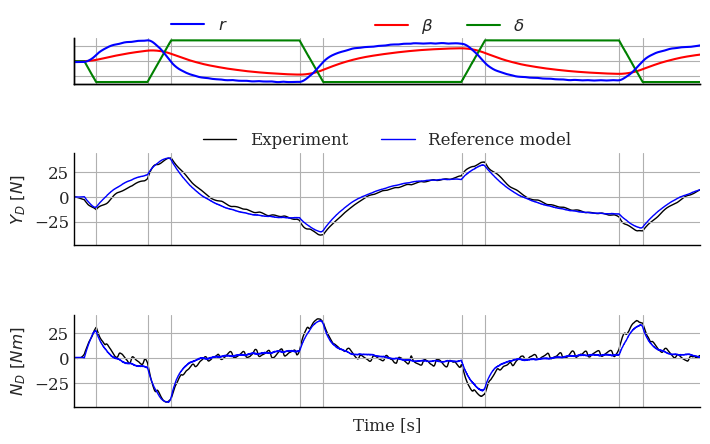

In [677]:
fig = plot_compare_model_forces(model=model, models=models, data=data_MDL, keys=['Y_D','N_D'], styles=styles)
fig.axes[0].legend(loc='upper center', bbox_to_anchor=(0.6, 1.8), ncol=2)
fig.axes[3].legend(loc='upper center', bbox_to_anchor=(0.2, 1.8), ncol=1)
fig.axes[1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.4), ncol=2)
plt.tight_layout()
fig.savefig(paper.file_path_with_nb_ref("VCT_regression_ID.pdf"))
fig.savefig(paper.file_path_with_nb_ref("VCT_regression_ID.svg"))

[01/31/24 13:28:38] WARNING  /home/maa/dev/PHD/src/phd/visualization/plot_prediction.py:252:        ]8;id=337713;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=766801;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             UserWarning: The figure layout has changed to tight                                   
                               plt.tight_layout()                                                                  
                                                                                                                   

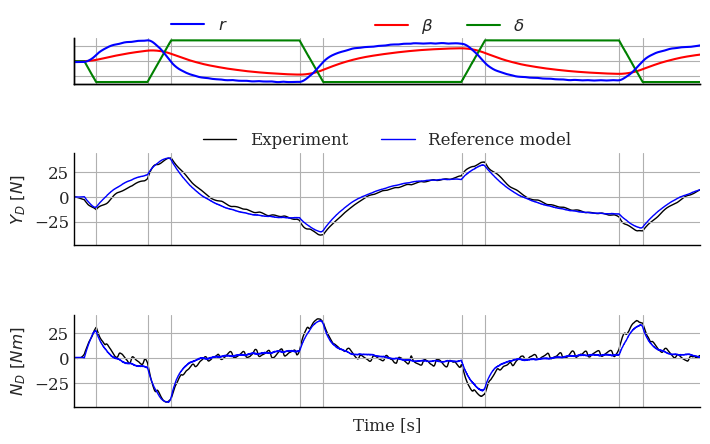

In [678]:
fig = plot_compare_model_forces(model=model, models=models, data=data_MDL, keys=['Y_D','N_D'], styles=styles)
fig.axes[0].legend(loc='upper center', bbox_to_anchor=(0.6, 1.8), ncol=2)
fig.axes[3].legend(loc='upper center', bbox_to_anchor=(0.2, 1.8), ncol=1)
fig.axes[1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.4), ncol=2)
plt.tight_layout()
fig.savefig(paper.file_path_with_nb_ref("VCT_regression_ID.pdf"))
fig.savefig(paper.file_path_with_nb_ref("VCT_regression_ID.svg"))

[01/31/24 13:28:39] WARNING  /home/maa/dev/PHD/src/phd/visualization/plot_prediction.py:252:        ]8;id=98485;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=700453;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             UserWarning: The figure layout has changed to tight                                   
                               plt.tight_layout()                                                                  
                                                                                                                   

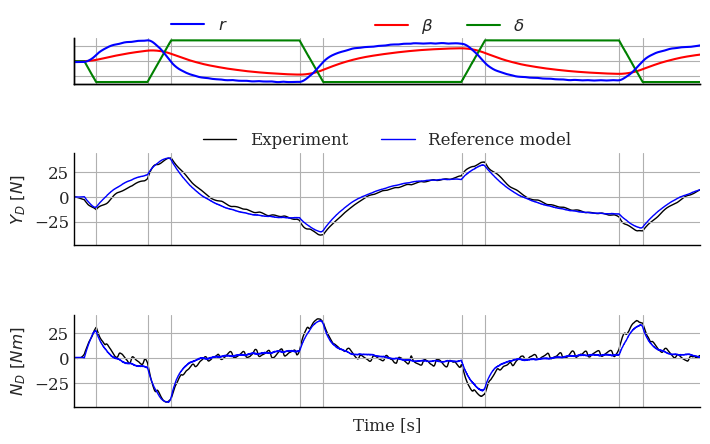

In [679]:
fig = plot_compare_model_forces(model=model, models=models, data=data_MDL, keys=['Y_D','N_D'], styles=styles)
fig.axes[0].legend(loc='upper center', bbox_to_anchor=(0.6, 1.8), ncol=2)
fig.axes[3].legend(loc='upper center', bbox_to_anchor=(0.2, 1.8), ncol=1)
fig.axes[1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.4), ncol=2)
plt.tight_layout()
fig.savefig(paper.file_path_with_nb_ref("VCT_regression_ID.pdf"))
fig.savefig(paper.file_path_with_nb_ref("VCT_regression_ID.svg"))

[01/31/24 13:28:40] WARNING  /home/maa/dev/PHD/src/phd/visualization/plot_prediction.py:252:        ]8;id=46223;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=295083;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             UserWarning: The figure layout has changed to tight                                   
                               plt.tight_layout()                                                                  
                                                                                                                   

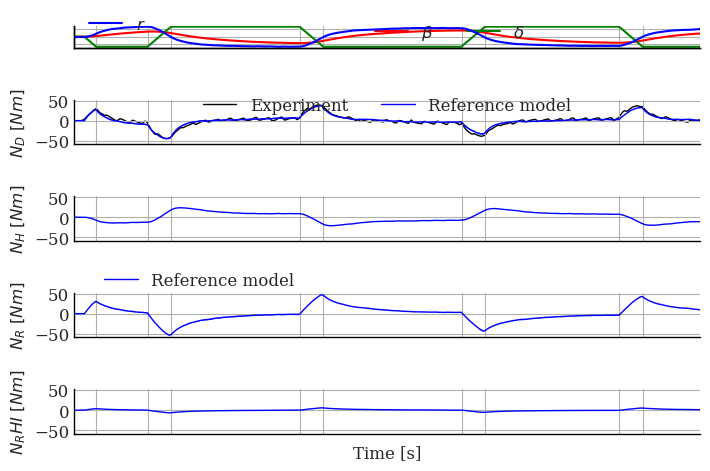

In [680]:
fig = plot_compare_model_forces(model=model, models=models, data=data_MDL, keys=['N_D','N_H','N_R','N_RHI'], styles=styles)
fig.axes[0].legend(loc='upper center', bbox_to_anchor=(0.6, 1.8), ncol=2)
fig.axes[3].legend(loc='upper center', bbox_to_anchor=(0.2, 1.8), ncol=1)
fig.axes[1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.4), ncol=2)
plt.tight_layout()

In [681]:
df_prediction = predict(model=model, data=data_MDL)

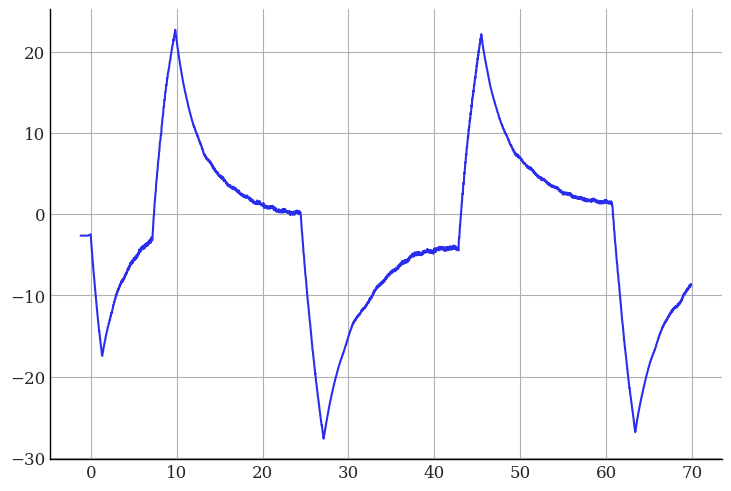

In [682]:
fig,ax=plt.subplots()
ax.plot(df_prediction.index, np.rad2deg(df_prediction['alpha_stbd']))
ax.grid(True)

In [683]:
np.rad2deg(df_prediction['alpha_stbd']).abs().max()

27.60891143100424

## Simulations

In [684]:
model_MDL = model

In [685]:
#model_MDL.parameters["Yv"]=-0.010521356616003574
#model_MDL.parameters['kappa_r']=1.2785108977943178
#model_MDL.parameters['kappa_v']=0.8498504154023542

In [686]:
#model_MDL.parameters["Nr"]=-0.0008468625137345155/1.5*1.3
#model_MDL.parameters["kappa_r"]=2.243424533243592/1.7

In [687]:
#model_MDL.parameters["Nv"]=-0.0029206669315391108*1.3
#model_MDL.parameters["Yv"]=-0.006373161059496452*1.3

## Open loop simulation

In [688]:
def postprocess(df):
    df['V'] = df['U'] = np.sqrt(df['u']**2 + df['v']**2)
    df['beta'] = -np.arctan2(df['v'],df['u'])
    df['beta_deg'] = np.rad2deg(df['beta'])

In [689]:
result_open_loop = model_MDL.simulate(data_MDL)
postprocess(result_open_loop)
#result_open_loop['V'] = np.sqrt(result_open_loop['u']**2+result_open_loop['v']**2)
#result_open_loop['beta'] = np.arctan2(-result_open_loop['v'],result_open_loop['u'])
#result_open_loop['beta_deg'] = np.rad2deg(result_open_loop['beta'])

## Closed loop simulation

In [690]:
u0 = data_MDL.iloc[0]['u']
rev = None
rudder_rate = 2.32 * np.sqrt(model.ship_parameters["scale_factor"])
angle = 10
twa=None
tws=None
neutral_rudder_angle=0
thrust_port = data_MDL['thrust_port']
thrust_stbd = data_MDL['thrust_stbd']
result_closed_loop = vessel_manoeuvring_models.models.IMO_simulations.zigzag(
        model=model_MDL,
        u0=u0,
        rev=rev,
        thrust_port=thrust_port,
        thrust_stbd=thrust_stbd,
        rudder_rate=rudder_rate,
        angle=angle,
        heading_deviation=angle,
        twa=twa,
        tws=tws,
        neutral_rudder_angle=neutral_rudder_angle,
        t_max=data_MDL.index[-1],
    )

In [691]:
postprocess(result_closed_loop)

[01/31/24 13:28:49] WARNING  /home/maa/dev/VesselManoeuvringModels/vessel_manoeuvring_models/visual ]8;id=719243;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=653638;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             ization/plot.py:127: UserWarning: The figure layout has changed to                    
                             tight                                                                                 
                               plt.tight_layout()                                                                  
                                                                                                                   

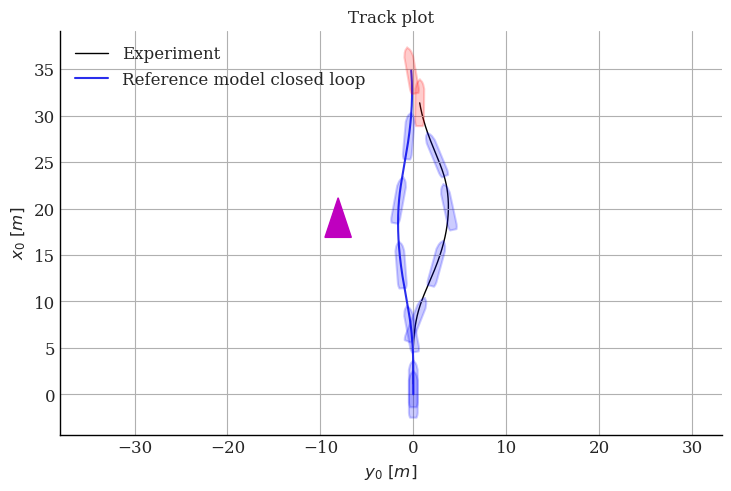

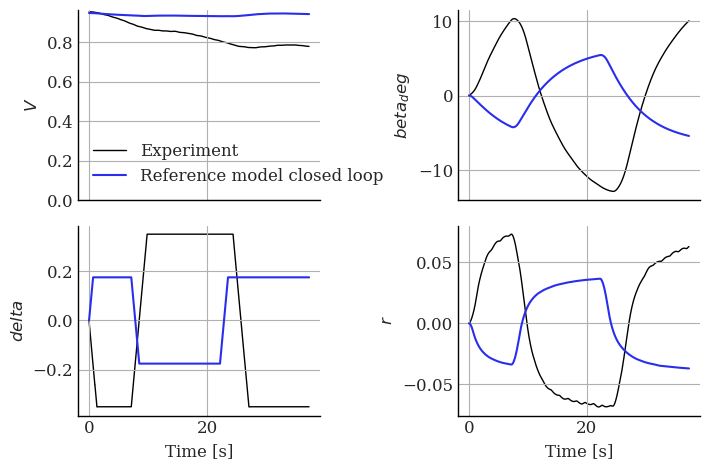

In [692]:
dataframes = {
    'Experiment': data_MDL.loc[0:result_closed_loop.index[-1]],
    #'Reference model': result_open_loop,
    'Reference model closed loop': result_closed_loop,
}
track_plots(dataframes=dataframes,lpp=ship_data['L'],beam=ship_data['B'], styles=styles);
plot(dataframes=dataframes, keys=['V','beta_deg','r','delta'], styles=styles);

In [693]:
def plot_zigzag(df, ax=None, label=None, **kwargs):
    
    if ax is None:
        fig,ax=plt.subplots()
    
    lines = ax.plot(df.index, np.rad2deg(df['psi']), label=label,**kwargs)
    color = lines[-1].get_color()
    ax.plot(df.index, np.rad2deg(-df['delta']), '--', color=color, label='__none__',**kwargs)
        

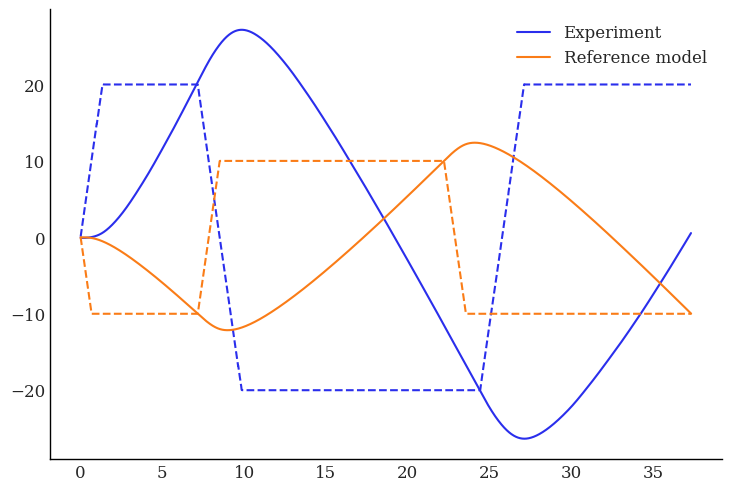

In [694]:
fig,ax=plt.subplots()
df_ = data_MDL.loc[0:result_closed_loop.index[-1]].copy()
plot_zigzag(df=df_,ax=ax, label='Experiment')
plot_zigzag(df=result_closed_loop,label='Reference model', ax=ax)
ax.legend()

In [695]:
data = data_MDL
forces_from_motions = model.forces_from_motions(data=data)
df_predict = predict(model=model, data=data)

<Axes: >

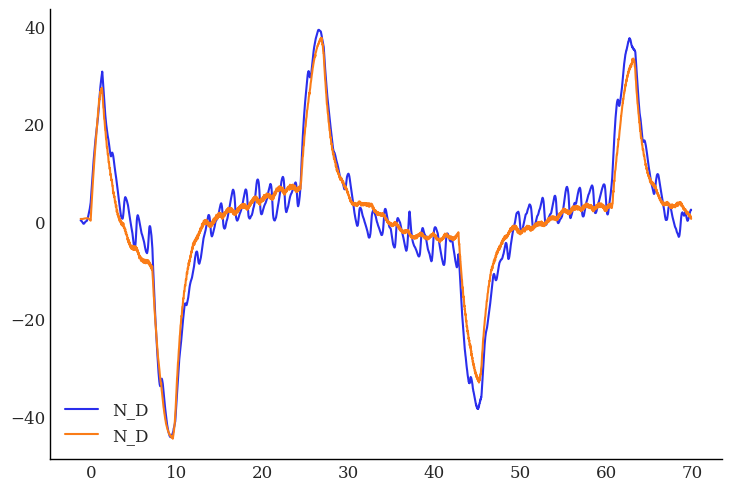

In [696]:
fig,ax=plt.subplots()
forces_from_motions.plot(y='N_D',ax=ax)
df_predict.plot(y='N_D', ax=ax)

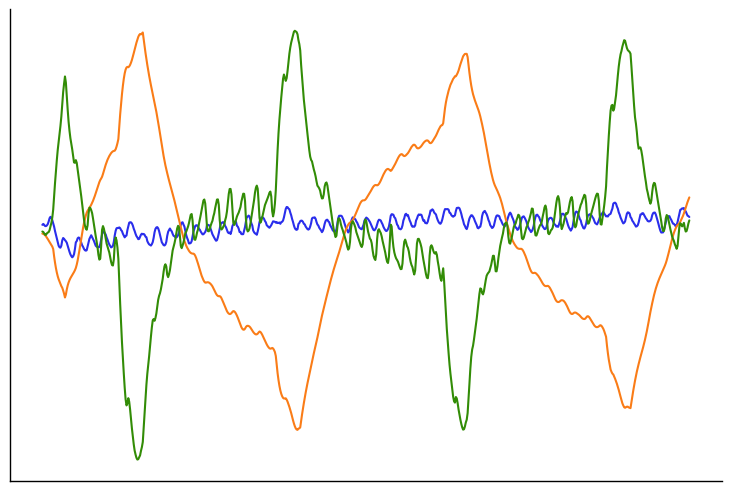

In [697]:
fig,ax=plt.subplots()
forces_from_motions.iloc[::10].plot(y=['X_D','Y_D','N_D'],ax=ax)
ax.set_xlabel('')
ax.set_ylabel('')
ax.get_legend().set_visible(False)
ax.set_yticklabels([]);
ax.set_xticklabels([]);
fig.savefig(paper.file_path_with_nb_ref("workflow_ID.svg"))

## Other tests

In [698]:
time_series_meta_data = catalog.load(f"{ship}.time_series_meta_data")

[01/31/24 13:28:50] INFO     Loading data from 'wPCC.time_series_meta_data' (CSVDataSet)...     ]8;id=748465;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=218665;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

In [699]:
_ = []
ids = tests_ek_smooth_joined['id'].unique()
for id in ids:
    
    loader = tests_ek_smooth[str(id)]
    data = loader()
    preprocess(data)
    try:
        s = score(model=model, data=data)
    except:
        print(f"Skipping {id}")
        continue
        
    _.append(pd.Series(s, name=id))
    
df_scores = pd.DataFrame(_)

In [700]:
steals = [
    'test_type',
    'angle1',
    'ship_speed',
]
for steal in steals:
    df_scores[steal] = time_series_meta_data[steal]

In [701]:
mask = df_scores['test_type'] == 'rodergrundvinkel'
df_scores.loc[mask,'test_type'] = 'yaw rate'

mask = df_scores['test_type'] == 'reference speed'
df_scores.loc[mask,'test_type'] = 'ref. speed'

mask = df_scores['test_type'] == 'zigzag'
df_scores.loc[mask,'Description'] = df_scores.loc[mask].apply(lambda x:f"{x['test_type']}{int(x['angle1'])}/{int(x['angle1'])}", axis=1)
df_scores.loc[~mask,'Description'] = df_scores.loc[~mask,'test_type']

In [702]:
df_scores.sort_values(by=['Description','ship_speed'], inplace=True, ascending=False)

In [703]:
df_scores_table = df_scores[['Description','ship_speed','X_D','Y_D','N_D']].copy()
df_scores_table.rename(columns={
    'ship_speed': r'V',
    'X_D': r'$X_D$ $[N]$',
    'Y_D': r'$Y_D$ $[Nm]$',
    'N_D': r'$N_D$ $[Nm]$',
    
}, inplace=True)

In [704]:
df_scores_table.to_csv(paper.file_path_with_nb_ref("reference_model_mean_average_error.csv", directory='tables'), index=False)

In [705]:
df_scores_table

,Description,V,$X_D$ $[N]$,$Y_D$ $[Nm]$,$N_D$ $[Nm]$
22772,zigzag20/20,0.96177,0.989445,2.861612,2.862007
22773,zigzag20/20,0.96177,1.013662,2.524593,2.956920
22765,zigzag10/10,0.96177,0.852653,1.681530,1.717639
22770,zigzag10/10,0.96177,1.367992,1.716987,1.786113
